# Random Forest Classifier

The goal of this notebook is to classify our samples using a RandomForest model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)


We need to identify the optimal 

In [5]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


from sklearn.ensemble import RandomForestClassifier

In [2]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g');

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [32]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined



def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    
    train = average_speakers(train)
    
    return train, test


train, test = load_data()

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33228 entries, 0 to 33227
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   speaker     33228 non-null  object 
 1   word        33228 non-null  object 
 2   feature_1   33228 non-null  float64
 3   feature_2   33228 non-null  float64
 4   feature_3   33228 non-null  float64
 5   feature_4   33228 non-null  float64
 6   feature_5   33228 non-null  float64
 7   feature_6   33228 non-null  float64
 8   feature_7   33228 non-null  float64
 9   feature_8   33228 non-null  float64
 10  feature_9   33228 non-null  float64
 11  feature_10  33228 non-null  float64
 12  feature_11  33228 non-null  float64
 13  feature_12  33228 non-null  float64
 14  accent      33228 non-null  object 
dtypes: float64(12), object(3)
memory usage: 4.1+ MB


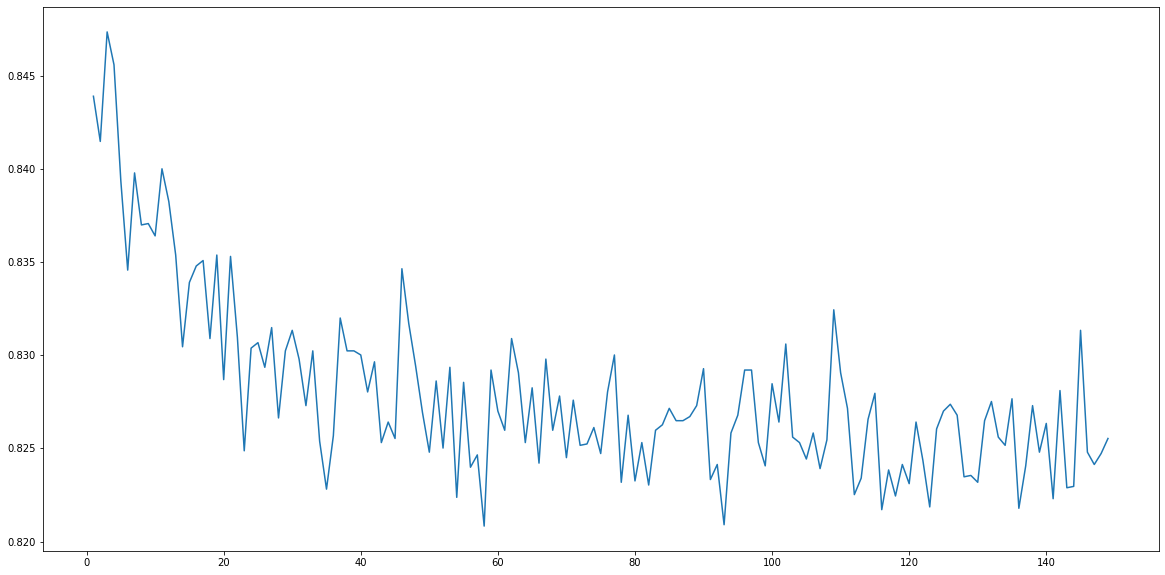

In [35]:
def fit_rf(train, test, word=None, features = None, k = None, display_conf = False):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
    
    
    tree_counts = []
    tree_count_score = []
    
    if k is None:
        fig, ax = plt.subplots(figsize=(20,10))

        for i in np.arange(1, 150, 1):
            tree_counts.append(i)
            clf = RandomForestClassifier(n_estimators = i).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            tree_count_score.append(1 - np.mean(y_pred == y_test))
            
        opt_score_idx = np.where(tree_count_score == np.amin(tree_count_score))
        opt_tree = tree_counts[opt_score_idx[0][0]]

        sns.lineplot(x=tree_counts, y=tree_count_score, ax=ax, markers=True)

        return tree_counts, tree_count_score, opt_score_idx, opt_tree
    
    clf = RandomForestClassifier(n_estimators = k).fit(X_train, y_train)
    y_pred = clf.predict(X_test)  
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    conf_mat = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if display_conf:
        plot_conf_matconf(conf_mat)
        print(f"Random Forest mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
        print(conf_df)
    
    return conf_df
    
    
    
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(train, test)

In [36]:
print(f"The optimal tree count is: {opt_tree}")

The optimal tree count is: 58


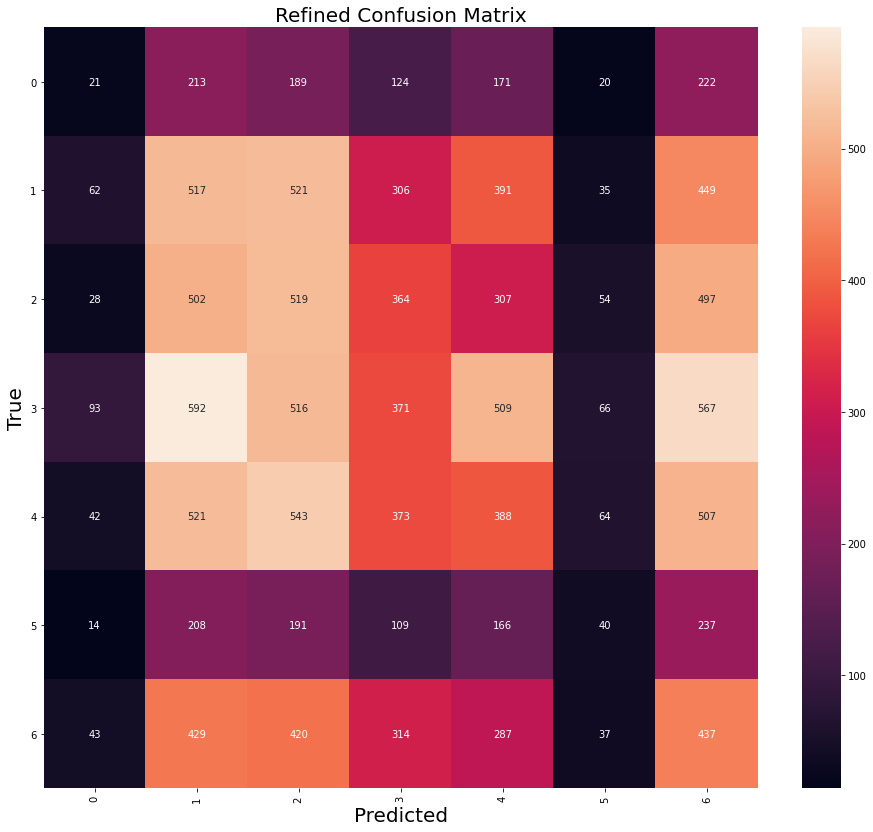

Random Forest mislabeled points out of a total 13596 points : 11303
                  DR1          DR2          DR3          DR4          DR5  \
precision    0.069307     0.173374     0.179027     0.189189     0.174854   
recall       0.021875     0.226655     0.228534     0.136699     0.159147   
f1-score     0.033254     0.196466     0.200774     0.158717     0.166631   
support    960.000000  2281.000000  2271.000000  2714.000000  2438.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.126582     0.149863  0.168653      0.151742      0.163670  
recall       0.041451     0.222166  0.168653      0.148075      0.168653  
f1-score     0.062451     0.178988  0.168653      0.142469      0.160735  
support    965.000000  1967.000000  0.168653  13596.000000  13596.000000  


In [37]:
rf_conf = fit_rf(train, test, k=58, display_conf=True)

In [38]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test

In [39]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      4985
North    4206
South    2438
West     1967
Name: accent, dtype: int64

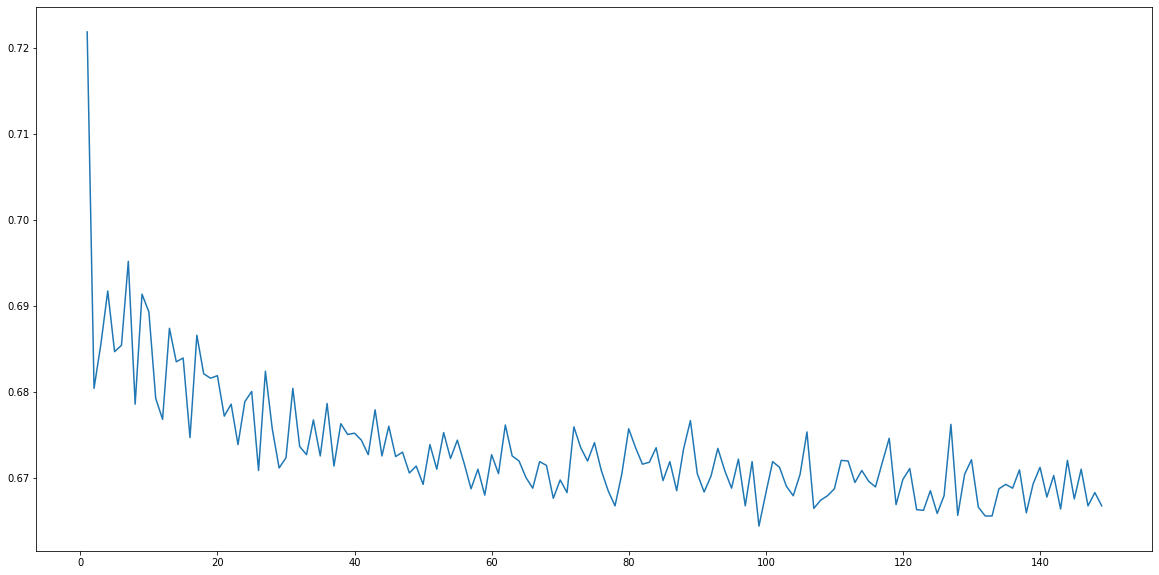

In [40]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(condensed_train, condensed_test)

In [41]:
opt_tree

99

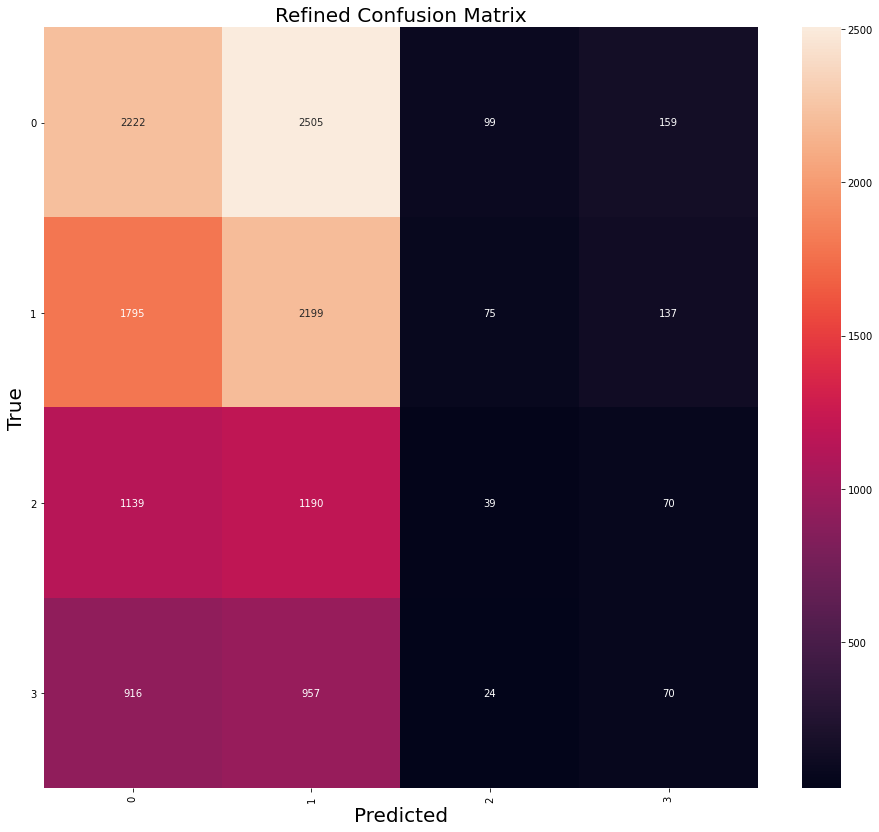

Random Forest mislabeled points out of a total 13596 points : 9066
                   Mid        North        South         West  accuracy  \
precision     0.365942     0.320975     0.164557     0.160550  0.333186   
recall        0.445737     0.522825     0.015997     0.035587  0.333186   
f1-score      0.401917     0.397757     0.029159     0.058261  0.333186   
support    4985.000000  4206.000000  2438.000000  1967.000000  0.333186   

              macro avg  weighted avg  
precision      0.253006      0.286204  
recall         0.255036      0.333186  
f1-score       0.221773      0.284070  
support    13596.000000  13596.000000  


In [42]:
rf_conf = fit_rf(condensed_train, condensed_test, k=99, display_conf=True)